<a href="https://colab.research.google.com/github/borja-izquierdo/portfolio/blob/main/Value_at_Risk_(VaR)_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm

## Set time from to a certain numbers of years

In [16]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

## Create a list of tickers

In [17]:
tickers = ['SPY','BND','GLD','QQQ','VTI']

## Download the daily adjusted close prices for the tickers

In [18]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
  data = yf.download(ticker, start = startDate, end = endDate)
  adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-11-17   63.965069  48.300018   72.650002   24.816864   31.666996
2008-11-18   65.170021  48.332382   72.510002   24.790613   31.960897
2008-11-19   60.993954  48.500664   72.260002   23.495979   30.024099
2008-11-20   56.466179  48.461834   73.449997   22.358799   28.019493
2008-11-21   59.512135  48.222343   78.849998   23.329782   29.609602
...                ...        ...         ...         ...         ...
2023-11-06  435.690002  69.500000  183.350006  369.209991  215.500000
2023-11-07  436.929993  6

## Calculate the daily log returns and drop any NAs

In [21]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2008-11-18  0.018662  0.000670 -0.001929 -0.001058  0.009238
2008-11-19 -0.066225  0.003476 -0.003454 -0.053636 -0.062513
2008-11-20 -0.077133 -0.000801  0.016334 -0.049609 -0.069100
2008-11-21  0.052538 -0.004954  0.070942  0.042511  0.055198
2008-11-24  0.066996 -0.004305  0.025790  0.059322  0.057852
...              ...       ...       ...       ...       ...
2023-11-06  0.002298 -0.004307 -0.007823  0.004071  0.000418
2023-11-07  0.002842  0.005023 -0.004154  0.009408  0.002965
2023-11-08  0.000732  0.003145 -0.010018  0.000644 -0.000139
2023-11-09 -0.007829 -0.007449  0.003975 -0.007725 -0.008551
2023-11-10  0.015484  0.001867 -0.010970  0.022233  0.014778

[3771 rows x 5 columns]


## Create a function that will help us calculate portfolio expected returns

In [22]:
#We are assuming that future returns are based on past returns, which is not a reliable assumption

def expected_return(weights, log_returns):
  return np.sum(log_returns.mean()*weights)

In [23]:
#Create a function that will used to calculate portfolio standard deviation

def standard_deviation (weights, cov_matrix):
  variance = weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

## Create a covariance matrix for all the securities

In [26]:
cov_matrix = log_returns.cov()
print(cov_matrix)

          SPY           BND       GLD           QQQ       VTI
SPY  0.000140 -1.305954e-06  0.000008  1.483928e-04  0.000143
BND -0.000001  9.373210e-06  0.000009 -5.133101e-07 -0.000001
GLD  0.000008  8.536693e-06  0.000105  8.007137e-06  0.000009
QQQ  0.000148 -5.133101e-07  0.000008  1.826637e-04  0.000151
VTI  0.000143 -1.175289e-06  0.000009  1.514537e-04  0.000146


## Create an equally weighted portfolio and find total portfolio

In [27]:
portfolio_value = 100000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

## Create a function that gives a random Z-score based on normal distribution

In [28]:
def random_z_score():
  return np.random.normal(0,1)

## Create a function to calculate scenario Gain/Loss

In [39]:
days = 15

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
  return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

## Run 10000 simulations

In [40]:
simulations = 10000
scenarioReturn = []

for i in range(simulations):
  z_score = random_z_score()
  scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

## Specify a confidence interval and calculatr VaR

In [42]:
confidence_interval = 0.95
VaR = np.percentile(scenarioReturn, 100*(1 - confidence_interval))
print(VaR)

-1238.6705041617242


## Plot the results of all 10000 scenarios

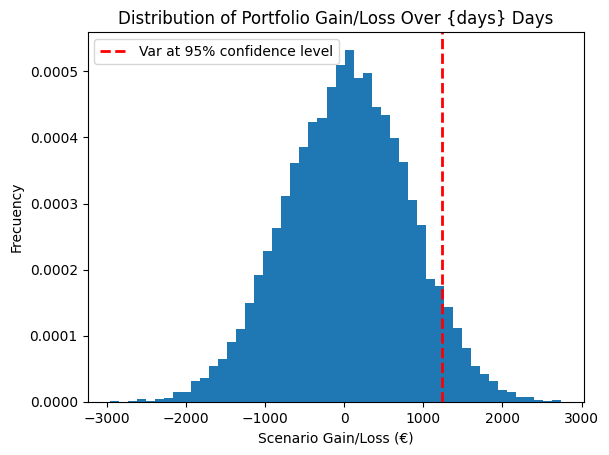

In [43]:
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss (€)')
plt.ylabel('Frecuency')
plt.title('Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'Var at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()